<a href="https://colab.research.google.com/github/ykitaguchi77/FundusPhoto/blob/main/FundusPhoto_cropped_img.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
from __future__ import print_function, division
!pip install torch_optimizer

import torch
import torch.nn as nn
import torch_optimizer as optim
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import math
import shutil
import csv
import pandas as pd
import glob
from PIL import Image


#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

#あればGPUを使用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
!nvidia-smi -L

#google driveをcolabolatoryにマウント
from google.colab import drive
drive.mount('/content/drive')



GPU 0: Tesla T4 (UUID: GPU-3a9c18ac-c5f8-9210-64aa-459f59f17af6)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
DATASET_NAME = 'cropped_img_trainval'
DATASET_PATH = '/content/drive/MyDrive/Deep_learning/FundusPhoto'
os.chdir(DATASET_PATH)

TRAIN_FOLDER_NAME = DATASET_NAME +'/train' #TRAINイメージのフォルダ
VAL_FOLDER_NAME = DATASET_NAME +'/val' #VALイメージのフォルダ
TEST_FOLDER_NAME = DATASET_NAME +'/test' #TESTイメージのフォルダ

FILENAME_LABELCSV = 'name_age.csv' #年齢の値のcsv
FILENAME_RESULTCSV = 'result.csv' #年齢推定結果を書き出すcsv

NET_NAME = "RepVGG-A2-train"
MODEL_PATH = '/content/drive/MyDrive/Deep_learning/FundusPhoto/model'
#OPTIMIZER_PATH = "./optimizer_multi.pth"
LOG_PATH = "./log_multi.txt"
ROC_PATH = "./roc_multi.png"
CHECKPOINT_COUNT = 10
EPOCH = 100
PATIENCE = 20 #early stopping patience; how long to wait after last time validation loss improved.
BATCH_SIZE = 16


# transforms param
PX = 224 #画像のサイズ
TRAIN_NORMALIZE_PARAM = [0.494, 0.296, 0.197], [0.14,  0.114, 0.072]
TRAIN_CROP_SCALE =(0.75,1.0)
TRAIN_BRIGHTNESS_PARAM = 0.2
TRAIN_CONTRAST_PARAM = 0.1
TRAIN_SATURATION_PARAM = 0.1
TRAIN_RANDOM_ROTATION = 3
TRAIN_HUE_PARAM = 0.02
VAL_NORMALIZE_PARAM = [0.494, 0.296, 0.197], [0.14,  0.114, 0.072]


In [30]:
#csvファイルを開く
df_labelcsv = pd.read_csv(FILENAME_LABELCSV)

#csvファイルを表示
print(df_labelcsv)

#ID,ageの列の値をリストとして取り出す
df_filename = df_labelcsv['filename'].values
df_age = df_labelcsv['age'].values

#CSVファイル内の画像数
print(len(df_labelcsv))

#画像フォルダ内の画像数
print(len(os.listdir(DATASET_PATH +"/"+ TRAIN_FOLDER_NAME))
+len(os.listdir(DATASET_PATH +"/"+ VAL_FOLDER_NAME))
+len(os.listdir(DATASET_PATH +"/"+ TEST_FOLDER_NAME)))


                   filename  age
0     img00085008_00_1R.jpg   61
1     img00085024_00_1R.jpg   29
2     img00241280_10_1R.jpg   51
3     img00265140_00_1R.jpg   29
4     img00265140_00_2L.jpg   29
...                     ...  ...
1409  img76791392_10_1R.jpg   38
1410  img76843122_10_1R.jpg   49
1411  img76843122_11_1R.jpg   49
1412  img76888512_00_1R.jpg   74
1413  img76888512_00_2L.jpg   74

[1414 rows x 2 columns]
1414
1414


In [31]:
class SimpleImageDataset(Dataset):
    def __init__(self, folder_path, csv_path, transform):
        self.transform = transform
        self.folder_path = folder_path
        self.item_paths = []
        self.item_dict = {}
        self.age = []

        for i in range(len(os.listdir(folder_path))):
              img_name = os.listdir(self.folder_path)[i]
              age_temp = df_labelcsv[df_labelcsv['filename'] == img_name].iloc[0,1] #age
              self.age.append(float(age_temp)/100)

              img_path = os.path.join(self.folder_path, img_name)
              self.item_paths.append(img_path)
              #self.item_dict[image_path] = self.age


    def __len__(self):
        return len(self.item_paths)

    def __getitem__(self, idx):
        image_path = self.item_paths[idx]
        pilr_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pilr_image)
        target = torch.tensor([self.age[idx]])      
        return tensor_image, target


train_data_transforms = transforms.Compose([
                transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(degrees=10),
                transforms.ToTensor(),
                ])
val_data_transforms = transforms.Compose([
                transforms.Resize(PX),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.ToTensor(),
                ]) 

train_dataset = SimpleImageDataset(os.path.join(DATASET_PATH, TRAIN_FOLDER_NAME), os.path.join(DATASET_PATH, FILENAME_LABELCSV), train_data_transforms)
val_dataset = SimpleImageDataset(os.path.join(DATASET_PATH, VAL_FOLDER_NAME), os.path.join(DATASET_PATH, FILENAME_LABELCSV),  val_data_transforms)
test_dataset = SimpleImageDataset(os.path.join(DATASET_PATH, TEST_FOLDER_NAME), os.path.join(DATASET_PATH, FILENAME_LABELCSV),  val_data_transforms)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)
test_loader = DataLoader(val_dataset, batch_size = 1, shuffle = False)


print(TRAIN_FOLDER_NAME + "_dataset_size：" + str(len(train_dataset)))
print(VAL_FOLDER_NAME + "_dataset_size：" + str(len(val_dataset)))
print(TEST_FOLDER_NAME + "_dataset_size：" + str(len(test_dataset)))

cropped_img_trainval/train_dataset_size：989
cropped_img_trainval/val_dataset_size：282
cropped_img_trainval/test_dataset_size：143


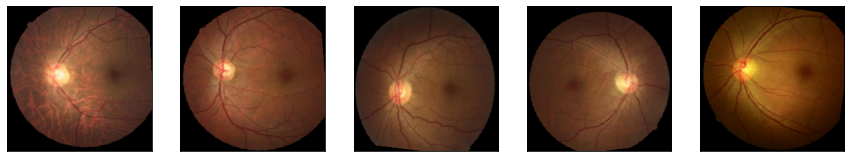

In [32]:
#水増し後の画像を可視化する関数
def show_img(dataset):
    plt.figure(figsize=(15, 3))
    for i in range(5):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)
        plt.subplot(1, 5, i+1)
        plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        plt.tick_params(bottom=False, left=False, right=False, top=False)
        plt.imshow(image)
        

#画像の可視化
show_img(train_dataset)

In [ ]:
print(train_dataset[1])

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), tensor([0.6100]))


#**Test with early-stopping**

In [33]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss



def train_model(model, loss_func, batch_size, optimizer, patience, n_epochs, device):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training

        running_corrects, train_acc= 0, 0

        for batch, (image_tensor, target) in enumerate(train_loader, 1):
            # convert batch-size labels to batch-size x 1 tensor
            #target = target.squeeze(1)
            target = target.view(len(target), 1)

            image_tensor = image_tensor.to(device)
            target = target.to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(image_tensor)
            # calculate the loss
            loss = loss_func(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()

            # record training loss
            train_losses.append(loss.item())


        ######################    
        # validate the model #
        ######################
       
        model.eval() # prep model for evaluation

        running_corrects, val_acc= 0, 0

        for image_tensor, target in val_loader:  
            #target = target.squeeze(1)         
            target = target.view(len(target), 1)

            image_tensor = image_tensor.to(device)
            target = target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(image_tensor)
            # calculate the loss
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'Epoch: [{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +'\n'
                     f'train_loss: {train_loss:.5f} ' +'\n'
                     f'valid_loss: {valid_loss:.5f} ' )
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        print('')

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

#**Define RepVGG-B3**

In [35]:
def conv_bn(in_channels, out_channels, kernel_size, stride, padding, groups=1):
    result = nn.Sequential()
    result.add_module('conv', nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                                  kernel_size=kernel_size, stride=stride, padding=padding, groups=groups, bias=False))
    result.add_module('bn', nn.BatchNorm2d(num_features=out_channels))
    return result

class RepVGGBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, groups=1, padding_mode='zeros', deploy=False):
        super(RepVGGBlock, self).__init__()
        self.deploy = deploy
        self.groups = groups
        self.in_channels = in_channels

        assert kernel_size == 3
        assert padding == 1

        padding_11 = padding - kernel_size // 2

        self.nonlinearity = nn.ReLU()

        if deploy:
            self.rbr_reparam = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                                      padding=padding, dilation=dilation, groups=groups, bias=True, padding_mode=padding_mode)

        else:
            self.rbr_identity = nn.BatchNorm2d(num_features=in_channels) if out_channels == in_channels and stride == 1 else None
            self.rbr_dense = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups)
            self.rbr_1x1 = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, padding=padding_11, groups=groups)
            print('RepVGG Block, identity = ', self.rbr_identity)


    def forward(self, inputs):
        if hasattr(self, 'rbr_reparam'):
            return self.nonlinearity(self.rbr_reparam(inputs))

        if self.rbr_identity is None:
            id_out = 0
        else:
            id_out = self.rbr_identity(inputs)

        return self.nonlinearity(self.rbr_dense(inputs) + self.rbr_1x1(inputs) + id_out)



#   This func derives the equivalent kernel and bias in a DIFFERENTIABLE way.
#   You can get the equivalent kernel and bias at any time and do whatever you want,
    #   for example, apply some penalties or constraints during training, just like you do to the other models.
#   May be useful for quantization or pruning.
    def get_equivalent_kernel_bias(self):
        kernel3x3, bias3x3 = self._fuse_bn_tensor(self.rbr_dense)
        kernel1x1, bias1x1 = self._fuse_bn_tensor(self.rbr_1x1)
        kernelid, biasid = self._fuse_bn_tensor(self.rbr_identity)
        return kernel3x3 + self._pad_1x1_to_3x3_tensor(kernel1x1) + kernelid, bias3x3 + bias1x1 + biasid

    def _pad_1x1_to_3x3_tensor(self, kernel1x1):
        if kernel1x1 is None:
            return 0
        else:
            return torch.nn.functional.pad(kernel1x1, [1,1,1,1])

    def _fuse_bn_tensor(self, branch):
        if branch is None:
            return 0, 0
        if isinstance(branch, nn.Sequential):
            kernel = branch.conv.weight
            running_mean = branch.bn.running_mean
            running_var = branch.bn.running_var
            gamma = branch.bn.weight
            beta = branch.bn.bias
            eps = branch.bn.eps
        else:
            assert isinstance(branch, nn.BatchNorm2d)
            if not hasattr(self, 'id_tensor'):
                input_dim = self.in_channels // self.groups
                kernel_value = np.zeros((self.in_channels, input_dim, 3, 3), dtype=np.float32)
                for i in range(self.in_channels):
                    kernel_value[i, i % input_dim, 1, 1] = 1
                self.id_tensor = torch.from_numpy(kernel_value).to(branch.weight.device)
            kernel = self.id_tensor
            running_mean = branch.running_mean
            running_var = branch.running_var
            gamma = branch.weight
            beta = branch.bias
            eps = branch.eps
        std = (running_var + eps).sqrt()
        t = (gamma / std).reshape(-1, 1, 1, 1)
        return kernel * t, beta - running_mean * gamma / std

    def repvgg_convert(self):
        kernel, bias = self.get_equivalent_kernel_bias()
        return kernel.detach().cpu().numpy(), bias.detach().cpu().numpy(),



class RepVGG(nn.Module):

    def __init__(self, num_blocks, num_classes=1000, width_multiplier=None, override_groups_map=None, deploy=False):
        super(RepVGG, self).__init__()

        assert len(width_multiplier) == 4

        self.deploy = deploy
        self.override_groups_map = override_groups_map or dict()

        assert 0 not in self.override_groups_map

        self.in_planes = min(64, int(64 * width_multiplier[0]))

        self.stage0 = RepVGGBlock(in_channels=3, out_channels=self.in_planes, kernel_size=3, stride=2, padding=1, deploy=self.deploy)
        self.cur_layer_idx = 1
        self.stage1 = self._make_stage(int(64 * width_multiplier[0]), num_blocks[0], stride=2)
        self.stage2 = self._make_stage(int(128 * width_multiplier[1]), num_blocks[1], stride=2)
        self.stage3 = self._make_stage(int(256 * width_multiplier[2]), num_blocks[2], stride=2)
        self.stage4 = self._make_stage(int(512 * width_multiplier[3]), num_blocks[3], stride=2)
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.linear = nn.Linear(int(512 * width_multiplier[3]), num_classes)


    def _make_stage(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        blocks = []
        for stride in strides:
            cur_groups = self.override_groups_map.get(self.cur_layer_idx, 1)
            blocks.append(RepVGGBlock(in_channels=self.in_planes, out_channels=planes, kernel_size=3,
                                      stride=stride, padding=1, groups=cur_groups, deploy=self.deploy))
            self.in_planes = planes
            self.cur_layer_idx += 1
        return nn.Sequential(*blocks)

    def forward(self, x):
        out = self.stage0(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.gap(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


optional_groupwise_layers = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
g2_map = {l: 2 for l in optional_groupwise_layers}
g4_map = {l: 4 for l in optional_groupwise_layers}

def create_RepVGG_A0(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[0.75, 0.75, 0.75, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_A1(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[1, 1, 1, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_A2(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[1.5, 1.5, 1.5, 2.75], override_groups_map=None, deploy=deploy)

def create_RepVGG_B0(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[1, 1, 1, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B1(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=None, deploy=deploy)

def create_RepVGG_B1g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B1g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=g4_map, deploy=deploy)


def create_RepVGG_B2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B2g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B2g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=g4_map, deploy=deploy)


def create_RepVGG_B3(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B3g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B3g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=g4_map, deploy=deploy)


func_dict = {
'RepVGG-A0': create_RepVGG_A0,
'RepVGG-A1': create_RepVGG_A1,
'RepVGG-A2': create_RepVGG_A2,
'RepVGG-B0': create_RepVGG_B0,
'RepVGG-B1': create_RepVGG_B1,
'RepVGG-B1g2': create_RepVGG_B1g2,
'RepVGG-B1g4': create_RepVGG_B1g4,
'RepVGG-B2': create_RepVGG_B2,
'RepVGG-B2g2': create_RepVGG_B2g2,
'RepVGG-B2g4': create_RepVGG_B2g4,
'RepVGG-B3': create_RepVGG_B3,
'RepVGG-B3g2': create_RepVGG_B3g2,
'RepVGG-B3g4': create_RepVGG_B3g4,
}
def get_RepVGG_func_by_name(name):
    return func_dict[name]



#   Use this for converting a customized model with RepVGG as one of its components (e.g., the backbone of a semantic segmentation model)
#   The use case will be like
#   1.  Build train_model. For example, build a PSPNet with a training-time RepVGG as backbone
#   2.  Train train_model or do whatever you want
#   3.  Build deploy_model. In the above example, that will be a PSPNet with an inference-time RepVGG as backbone
#   4.  Call this func
#   ====================== the pseudo code will be like
#   train_backbone = create_RepVGG_B2(deploy=False)
#   train_backbone.load_state_dict(torch.load('RepVGG-B2-train.pth'))
#   train_pspnet = build_pspnet(backbone=train_backbone)
#   segmentation_train(train_pspnet)
#   deploy_backbone = create_RepVGG_B2(deploy=True)
#   deploy_pspnet = build_pspnet(backbone=deploy_backbone)
#   whole_model_convert(train_pspnet, deploy_pspnet)
#   segmentation_test(deploy_pspnet)
def whole_model_convert(train_model:torch.nn.Module, deploy_model:torch.nn.Module, save_path=None):
    all_weights = {}
    for name, module in train_model.named_modules():
        if hasattr(module, 'repvgg_convert'):
            kernel, bias = module.repvgg_convert()
            all_weights[name + '.rbr_reparam.weight'] = kernel
            all_weights[name + '.rbr_reparam.bias'] = bias
            print('convert RepVGG block')
        else:
            for p_name, p_tensor in module.named_parameters():
                full_name = name + '.' + p_name
                if full_name not in all_weights:
                    all_weights[full_name] = p_tensor.detach().cpu().numpy()
            for p_name, p_tensor in module.named_buffers():
                full_name = name + '.' + p_name
                if full_name not in all_weights:
                    all_weights[full_name] = p_tensor.cpu().numpy()

    deploy_model.load_state_dict(all_weights)
    if save_path is not None:
        torch.save(deploy_model.state_dict(), save_path)

    return deploy_model


#   Use this when converting a RepVGG without customized structures.
#   train_model = create_RepVGG_A0(deploy=False)
#   train train_model
#   deploy_model = repvgg_convert(train_model, create_RepVGG_A0, save_path='repvgg_deploy.pth')
def repvgg_model_convert(model:torch.nn.Module, build_func, save_path=None):
    converted_weights = {}
    for name, module in model.named_modules():
        if hasattr(module, 'repvgg_convert'):
            kernel, bias = module.repvgg_convert()
            converted_weights[name + '.rbr_reparam.weight'] = kernel
            converted_weights[name + '.rbr_reparam.bias'] = bias
        elif isinstance(module, torch.nn.Linear):
            converted_weights[name + '.weight'] = module.weight.detach().cpu().numpy()
            converted_weights[name + '.bias'] = module.bias.detach().cpu().numpy()
    del model

    deploy_model = build_func(deploy=True)
    for name, param in deploy_model.named_parameters():
        print('deploy param: ', name, param.size(), np.mean(converted_weights[name]))
        param.data = torch.from_numpy(converted_weights[name]).float()

    if save_path is not None:
        torch.save(deploy_model.state_dict(), save_path)

    return deploy_model





class mod_RepVGG(nn.Module):
    def __init__(self):
        super(mod_RepVGG, self).__init__()
        repVGG = model_ft
        self.repVGG = nn.Sequential(*list(model_ft.children())[:-1])
        self.fc = nn.Linear(in_features=2560, out_features=1) #out_featuresを1に

    def forward(self, x):
        x = self.repVGG(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

#**ConvNetの調整**

In [36]:
model_ft = create_RepVGG_B3(deploy=False)
#model_ft.load_state_dict(torch.load(MODEL_PATH)) 
model_ft = mod_RepVGG()

#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
loss_func = nn.MSELoss()

#Optimizer
optimizer_ft = torch.optim.AdamW(model_ft.parameters(), 0.0002)

RepVGG Block, identity =  None
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identi

In [37]:
model, train_loss, valid_loss = train_model(model_ft, loss_func, BATCH_SIZE, optimizer_ft, PATIENCE, EPOCH, device)


Epoch: [  1/100] 
train_loss: 0.19744 
valid_loss: 0.01215 
Validation loss decreased (inf --> 0.012147).  Saving model ...

Epoch: [  2/100] 
train_loss: 0.01920 
valid_loss: 0.00858 
Validation loss decreased (0.012147 --> 0.008583).  Saving model ...

Epoch: [  3/100] 
train_loss: 0.01724 
valid_loss: 0.01794 
EarlyStopping counter: 1 out of 20

Epoch: [  4/100] 
train_loss: 0.01780 
valid_loss: 0.03105 
EarlyStopping counter: 2 out of 20

Epoch: [  5/100] 
train_loss: 0.01938 
valid_loss: 0.02740 
EarlyStopping counter: 3 out of 20

Epoch: [  6/100] 
train_loss: 0.01398 
valid_loss: 0.00649 
Validation loss decreased (0.008583 --> 0.006486).  Saving model ...

Epoch: [  7/100] 
train_loss: 0.01355 
valid_loss: 0.01298 
EarlyStopping counter: 1 out of 20

Epoch: [  8/100] 
train_loss: 0.01337 
valid_loss: 0.01533 
EarlyStopping counter: 2 out of 20

Epoch: [  9/100] 
train_loss: 0.01329 
valid_loss: 0.00937 
EarlyStopping counter: 3 out of 20

Epoch: [ 10/100] 
train_loss: 0.01213 


#**Save network**

In [38]:
#ネットワークの保存
PATH = MODEL_PATH+'/'+DATASET_NAME+'.pth'
torch.save(model_ft.state_dict(), PATH)

FileNotFoundError: ignored

#**Draw Learning Curves**

In [ ]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.1) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

#**Evaluation using testset**

In [ ]:
import statistics

def my_round(x, d=0): #四捨五入
    p = 10 ** d
    return float(math.floor((x * p) + math.copysign(0.5, x)))/p


model.eval() # prep model for evaluation

outputs,targets,errors =[], [], []
for image_tensor, target in test_loader:  
      target = target.view(len(target), 1)         
      image_tensor = image_tensor.to(device)
      target = target.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(image_tensor)

      outputs.append((output[0]*100).item())      
      targets.append((target[0]*100).item())
      #print('estimate R:'+str(my_round(output[0,0].item()))+'mm, L:'+str(my_round(output[0,1].item()))+'mm / target R:'+str(target[0,0].item())+'mm, L:'+str(target[0,1].item())+'mm')

      errors.append((output[0]*100).item()-(target[0]*100).item())

AbsError = [abs(i) for i in errors]

print('AveError: '+str(statistics.mean(errors)))
print('StdError: '+str(statistics.stdev(errors)))
print('AveAbsError: '+str(statistics.mean(AbsError)))
print('StdAbsError: '+str(statistics.stdev(AbsError)))


#平均からの差分を補正
corrected_output = (np.array(outputs)-np.array(statistics.mean(errors))).tolist()
corrected_error = (np.array(corrected_output)-np.array(targets)).tolist()
corrected_AbsError = [abs(i) for i in corrected_error]

round_output = [my_round(i) for i in outputs]
round_corrected_AbsError = [my_round(i) for i in corrected_AbsError]

print('Corrected_AveAbsError: '+str(statistics.mean(corrected_AbsError)))
print('Corrected_StdAbsError: '+str(statistics.stdev(corrected_AbsError)))


#csvを作成して保存
columns = ["result"]
index = ["AveError", "StdError", "AveAbsError", "StdAbsError", "Corrected_AveAbsError", "Corrected_StdAbsError"]
df = pd.DataFrame(index=index, columns=columns)
df.iloc[0:6, 0] =[statistics.mean(errors),statistics.stdev(errors),statistics.mean(AbsError),statistics.stdev(AbsError), statistics.mean(corrected_AbsError),statistics.stdev(corrected_AbsError)]
print(df)

PATH = MODEL_PATH+'/'+DATASET_NAME+'.csv'
df.to_csv(index=True, path_or_buf=PATH)

In [ ]:
import seaborn as sns

#Draw Graphs（散布図)
df = pd.DataFrame({'estimate':outputs, 'target':targets})

sns.set_style('whitegrid')
sns.set_palette('gray')
figure = sns.lmplot(x='estimate', y='target', data=df)
plt.xlim(0,100)
plt.ylim(0,100)

PATH = PATH = MODEL_PATH+'/'+DATASET_NAME+'.png'
figure.savefig(PATH)

In [ ]:
#Bland-Altman-Plot 
def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')

bland_altman_plot(outputs, targets)
plt.title('Bland-Altman Plot')
plt.show()

In [ ]:
from sklearn import linear_model

estimate = df.loc[:,'estimate']
target = df.loc[:,'target']
clf = linear_model.LinearRegression()

# 説明変数xに "x1"のデータを使用
x = np.array([estimate]).T

# 目的変数yに "x2"のデータを使用
y = target.values

# 予測モデルを作成（単回帰）
clf.fit(x, y)

# パラメータ（回帰係数、切片）を抽出
[a] = clf.coef_
b = clf.intercept_

# パラメータの表示
print("回帰係数:", a)
print("切片:", b)
print("決定係数:", clf.score(x, y))

#平均値により補正した値
df['Corrected_estimate_1']=0
for i in range(len(df)):                                                                    
    df.iloc[i,2] = corrected_output[i]

#回帰直線により補正した値
df['Corrected_estimate_2']=0
for i in range(len(df)):
    df.iloc[i,3] = df.iloc[i,0]*a+b

#残差
df['Residual_error_1']=0
for i in range(len(df)):
    df.iloc[i,4] = df.iloc[i,2]-df.iloc[i,1]

#残差
df['Residual_error_2']=0
for i in range(len(df)):
    df.iloc[i,5] = df.iloc[i,3]-df.iloc[i,1]

In [ ]:
#平均近似バージョン
#Draw histogram
sns.distplot(
    df['Residual_error_1'], bins=13, color='#123456', label='residual_error',
    kde=False,
    rug=False
)
plt.legend() # 凡例を表示 
plt.show()   # ヒストグラムを表示


#Draw Graphs
sns.set_style('whitegrid')
sns.set_palette('gray')
sns.lmplot(x='Corrected_estimate_1', y='target', data=df)
plt.xlim(0,100)
plt.ylim(0,100)

corrected_AbsError = [abs(i) for i in df['Residual_error_1']]
print('AveError: '+str(statistics.mean(df['Residual_error_1'])))
print('StdError: '+str(statistics.stdev(df['Residual_error_1'])))
print('AveAbsError: '+str(statistics.mean(corrected_AbsError)))
print('StdAbsError: '+str(statistics.stdev(corrected_AbsError)))

In [ ]:
#Bland-Altman-Plot using corrected value (平均値により補正)

def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')


corrected_estimate = df.loc[:,'Corrected_estimate_1']
target = df.loc[:,'target']

bland_altman_plot(corrected_estimate, target)
plt.title('Bland-Altman Plot')
plt.show()

In [ ]:
#trainデータをtrainとtestデータに分割（8:2）
image_train, image_test, label_train, label_test = train_test_split(image, label, test_size=0.2)

print('Data load finished')
print('Data numbers for train: ' + repr(len(image_train)) + ', test: ' + repr(len(image_test)))


#値の正規化
image_train /= 255.0
image_test /= 255.0

label_train /= 100.0 #年齢は100で割る
label_test /= 100.0


#%%
#年齢推定モデル
def model_cnn1():
    input_img = Input(shape=(imagesize_process[1], imagesize_process[0], 3))
    
    x = Conv2D(16, kernel_size=3, strides=1, activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Conv2D(16, kernel_size=3, strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=2, strides=2)(x)
    
    x = Conv2D(32, kernel_size=3, strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, kernel_size=3, strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=2, strides=2)(x)
    
    x = Conv2D(64, kernel_size=3, strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=3, strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=2, strides=2)(x)
    
    x = Conv2D(128, kernel_size=3, strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=3, strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=2, strides=2)(x)
    
    x = Conv2D(256, kernel_size=3, strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, kernel_size=3, strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    
    x = Flatten()(x)
    
    x = Dense(64, activation='linear')(x)
    x = Dropout(0.1)(x)
    x = Dense(8, activation='linear')(x)
    x = Dropout(0.1)(x)
    
    x = Dense(1, activation='linear')(x)
    
    model = Model(inputs=input_img, outputs=x)
    
    return model


model = model_cnn1()

#モデル構造表示
#print(model.summary())


#学習の設定
from tensorflow.keras.optimizers import Adam
adam = Adam(lr=0.00001)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

#学習
training = model.fit(image_train, label_train,
                    epochs=50, batch_size=6, shuffle=True, validation_data=(image_test, label_test), verbose=1)


#学習済みモデルをファイルに保存
#モデル
json_string = model.to_json()
open('model.json', 'w').write(json_string)
#重み
model.save_weights('weight.hdf5')


#学習履歴表示
def plot_history(history):
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('mean absolute error')
    plt.xlabel('epoch')
    plt.ylabel('mae')
    plt.yscale('log')
    plt.legend(['mae', 'val_mae'], loc='lower right')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.yscale('log')
    plt.legend(['loss', 'val_loss'], loc='lower right')
    plt.show()
    
plot_history(training)


#testデータを用いた推定
result = model.predict(image_test, verbose=1)

#値の範囲を元に戻す
label_test = label_test*100.0
result = result*100.0

result_mse = mean_squared_error(label_test, result)
print('MSE : %.2f'%(result_mse ** 0.5))


#推定結果をcsvファイルに書き出し
f = open(FILENAME_RESULTCSV, 'w')
writer = csv.writer(f, lineterminator='\n')

savedata = ['true_age', 'estimate_age']
writer.writerow(savedata)

for i in range(len(label_test)):
    savedata = [label_test[i], result[i][0]]
    writer.writerow(savedata)

f.close()

KeyboardInterrupt: ignored